In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

## Data Import

In [2]:
df1=pd.read_csv('shipping_tag1.csv')
df2=pd.read_csv('shipping_tag2.csv')

In [3]:
df1.sample(10)


,tag,message
407097,InTransit,Envío clasificado en Centro Logístico
485328,InTransit,Package received for processing
281225,InTransit,Votre envoi vient de quitter son pays d'expédi...
507444,InTransit,Arrived at Post Office
145345,InTransit,In lavorazione presso il Centro Scambi Interna...
364207,InTransit,Received at Canada Post Induction Center
306946,InTransit,Item processed at facility
24144,Delivered,Delivered
356225,InTransit,EN ROUTE TO DHL ECOMMERCE
161748,InTransit,Chegou ao centro operacional


In [4]:
df2.head()

,tag,message,original_message
0,AttemptFail,"Vi har været forbi med din forsendelse, men vi...",NaN
1,AttemptFail,ATTEMPTED DELIVERY,NaN
2,AttemptFail,Delivery attempt,NaN
3,AttemptFail,Delivery was not possible. The recipient will ...,NaN
4,AttemptFail,"Vi har været forbi med din forsendelse, men vi...",NaN


In [5]:
del df2['original_message']

In [6]:
df=pd.concat([df1,df2])

In [7]:
df.head()

,tag,message
0,AttemptFail,Próba doręczenia
1,AttemptFail,Delivery attempt
2,AttemptFail,"Vi har været forbi med din forsendelse, men vi..."
3,AttemptFail,Delivery attempt
4,AttemptFail,Delivery attempted; recipient not home


## Data Cleaning

In [8]:
#check duplicates
sum(df.duplicated())

953786

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
#check messages with multiple tags
message_count=df['message'].value_counts()
dup_message=message_count[message_count>1].index
len(dup_message)

137

In [11]:
#drop those with multiple tags
df=df[~df['message'].isin(dup_message)]

In [12]:
## imbalance class
df.tag.value_counts()

InTransit             4661
Delivered             1862
AvailableForPickup     459
Exception              273
AttemptFail            216
InfoReceived           191
OutForDelivery         174
Name: tag, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'AttemptFail'),
  Text(1, 0, 'AvailableForPickup'),
  Text(2, 0, 'Delivered'),
  Text(3, 0, 'Exception'),
  Text(4, 0, 'InTransit'),
  Text(5, 0, 'InfoReceived'),
  Text(6, 0, 'OutForDelivery')])

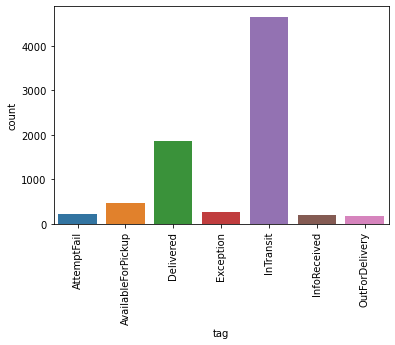

In [13]:
## imbalanced class, will need to do class balancing after train test split
sns.countplot(data=df,x='tag')
plt.xticks(rotation=90)

In [14]:
df['tag']=df['tag'].astype('category')
df['tag_code']=df['tag'].cat.codes
code_map=dict(zip(df['tag'].cat.codes,df['tag']))

In [15]:
df.sample(100)

,tag,message,tag_code
403836,InTransit,Item Despatched to Frodsham DO,4
38476,Delivered,The parcel has been delivered. Signed by: Carlos,2
263362,InTransit,Item Despatched to Brinklow DO,4
604528,InTransit,Arrived at DHL Delivery Facility ONTARIO SERV...,4
27321,Delivered,Your item has been successfully delivered and ...,2
...,...,...,...
253573,InTransit,Item Despatched to Putney DO,4
252334,InTransit,Shipment is in transit to destination BANGKOK ...,4
436986,InTransit,Departed Facility in QUEBEC SERVICE AREA - CA...,4
596563,InTransit,DISPATCH CLOS M.D. N. FILADELFEIAS,4


## NLP

In [16]:
import spacy
import spacy_fastlang
##from googletrans import Translator  ## online translator accessing google's api
import argostranslate.package       ## offline translator
import argostranslate.translate

In [17]:
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("language_detector")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [18]:
## build custom stopword list, not , n't ,out , re are important in the shipping, needs to keep 
real_stopwords=stopwords-{"not","n't","out",'re'}

In [19]:
## use ner tag to replace location, name
def ner_replacement(article):
    doc=nlp(article)
    ner=[(token.text,token.label_) for token in doc.ents]
    for text, entity in ner:
        article=article.replace(text,entity)
    return article


In [20]:
## eg
ner_replacement('The parcel has been delivered in los angeles')


'The parcel has been delivered in GPE'

In [21]:
## all argostranslate supporting langs
arg_support_lang=\
['ar',
 'az',
 'ca',
 'zh',
 'cs',
 'da',
 'nl',
 'eo',
 'fi',
 'fr',
 'de',
 'el',
 'he',
 'hi',
 'hu',
 'id',
 'ga',
 'it',
 'ja',
 'ko',
 'fa',
 'pl',
 'pt',
 'ru',
 'sk',
 'es',
 'sv',
 'th',
 'tr',
 'uk']

In [22]:

#Download and install Argos Translate package, run this cell first time running the code.
# from_code =arg_support_lang
# argostranslate.package.update_package_index()
# available_packages = argostranslate.package.get_available_packages()
# for code in from_code:
#     package_to_install = next(
#         filter(
#             lambda x: x.from_code == code, available_packages
#         )
#     )
#     argostranslate.package.install_from_path(package_to_install.download())
# package_to_install = next(
#         filter(
#             lambda x: x.to_code == 'en', available_packages
#         )
#     )
# argostranslate.package.install_from_path(package_to_install.download())

In [23]:
## Construct the tokenizer
def cust_lemmatizer(article):
    doc=nlp(article)
    # if doc._.language=='en':
    #     en_article=article
    if doc._.language in arg_support_lang:
        en_article = argostranslate.translate.translate(article, doc._.language, 'en')
    else:
        en_article=article
        # time.sleep(2)
        # en_article=Translator().translate(article, dest='en').text
    simplified_en_article=ner_replacement(en_article)
    clean_en_article=' '.join(re.findall("[\w _\-']+",simplified_en_article))
    doc1=nlp(clean_en_article)
    lemmas=[token.lemma_ for token in doc1 if not token.is_space]
    return [lemma for lemma in lemmas if lemma not in real_stopwords]
    
    

In [24]:
## e.g.
cust_lemmatizer("The parcel has been delivered in los angeles")


['parcel', 'deliver', 'GPE']

In [25]:
X=df.message.values
y=df.tag_code.values

In [26]:
# Train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=3)

In [27]:
# Class balancing on train test: oversampling all other classes other than InTransit
from imblearn.over_sampling import RandomOverSampler
sampler=RandomOverSampler(random_state=3,sampling_strategy='not majority')
X_train_rs,y_train_rs=sampler.fit_resample(X_train.reshape(-1, 1) ,y_train)

In [70]:
# Class distribution before and after balancing
print(np.unique(y_train,return_counts=True))
print(np.unique(y_train_rs,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6], dtype=int8), array([ 173,  367, 1490,  218, 3728,  153,  139], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int8), array([3728, 3728, 3728, 3728, 3728, 3728, 3728], dtype=int64))


In [29]:
## vectorize messages
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=cust_lemmatizer,ngram_range=(1,2),min_df=3)

In [30]:
X_train_vector=vectorizer.fit_transform(X_train_rs[:,0])

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
X_test_vector=vectorizer.transform(X_test)

In [33]:
print(X_train_vector.toarray().shape)
print(X_test_vector.toarray().shape)

(26096, 4164)
(1568, 4164)


## Modeling

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [35]:
## Algorithm, hyperparamter gridsearch
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {
            'C': [1, 5,10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale','auto']
        }  
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params' : {
                'max_depth': [4, 6, 8],
                'n_estimators': [ 100, 250,500,750],
                "learning_rate": [0.01,0.1,0.3],
                'colsample_bytree': np.arange(0.5, 1.0, 0.1),
                'colsample_bylevel': np.arange(0.5, 1.0, 0.1)
        }
    },
     'nb' : {
        'model': MultinomialNB(),
        'params': {
            'alpha': np.arange(1,10,1)
        }
     },
    'logistics regression' : {
    'model': LogisticRegression(),
    'params': {
        'penalty': ['l2',None],
        'solver': ['lbfgs','newton-cg','sag','saga']
        }
    }
}

In [36]:
scores = []

for model_name, mp in model_params.items():
    model =  RandomizedSearchCV(mp['model'], mp['params'], cv=3, n_iter=20)
    model.fit(X_train_vector, y_train_rs)
    scores.append({
        'model': model_name,
        'best_score': round(model.best_score_,2),
        'best_params': model.best_params_
    })
    
pd.DataFrame(scores,columns=['model','best_score','best_params'])

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warning

,model,best_score,best_params
0,svm,0.99,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}"
1,xgboost,0.99,"{'n_estimators': 750, 'max_depth': 6, 'learnin..."
2,nb,0.96,{'alpha': 1}
3,logistics regression,0.99,"{'solver': 'newton-cg', 'penalty': None}"


In [50]:
xgb=XGBClassifier(n_estimators=750, max_depth=6, learning_rate=0.1,colsample_bylevel=0.6,colsample_bytree= 0.8)
xgb.fit(X_train_vector, y_train_rs)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=750, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [38]:
svm=SVC(kernel='rbf',gamma='scale',C=10,probability=True)
svm.fit(X_train_vector, y_train_rs)

SVC(C=10, probability=True)

In [39]:
lr=LogisticRegression(solver='newton-cg',penalty=None)
lr.fit(X_train_vector, y_train_rs)

LogisticRegression(penalty=None, solver='newton-cg')

In [51]:
## SVM,XGboost and logistics regression all have similar performance
print('SVM:',svm.score(X_test_vector,y_test))
print('XGBoost:',xgb.score(X_test_vector,y_test))
print('Logistics Regression:',lr.score(X_test_vector,y_test))

SVM: 0.9540816326530612
XGBoost: 0.9585459183673469
Logistics Regression: 0.9534438775510204


In [52]:
## further comparison
from sklearn.metrics import classification_report

print('SVM: \n', classification_report(y_test,svm.predict(X_test_vector),target_names=code_map.values()))

SVM: 
                     precision    recall  f1-score   support

       AttemptFail       0.82      0.74      0.78        43
AvailableForPickup       0.97      0.93      0.95        92
         Delivered       0.97      0.98      0.97       372
         Exception       0.81      0.76      0.79        55
         InTransit       0.96      0.98      0.97       933
      InfoReceived       0.87      0.71      0.78        38
    OutForDelivery       0.97      0.86      0.91        35

          accuracy                           0.95      1568
         macro avg       0.91      0.85      0.88      1568
      weighted avg       0.95      0.95      0.95      1568



In [53]:
print('XGBoost: \n', classification_report(y_test,xgb.predict(X_test_vector),target_names=code_map.values()))

XGBoost: 
                     precision    recall  f1-score   support

       AttemptFail       0.83      0.81      0.82        43
AvailableForPickup       0.98      0.97      0.97        92
         Delivered       0.98      0.97      0.97       372
         Exception       0.78      0.78      0.78        55
         InTransit       0.97      0.98      0.97       933
      InfoReceived       0.88      0.79      0.83        38
    OutForDelivery       0.97      0.83      0.89        35

          accuracy                           0.96      1568
         macro avg       0.91      0.88      0.89      1568
      weighted avg       0.96      0.96      0.96      1568



In [54]:
print('Logistics Regression: \n', classification_report(y_test,lr.predict(X_test_vector),target_names=code_map.values()))

Logistics Regression: 
                     precision    recall  f1-score   support

       AttemptFail       0.88      0.81      0.84        43
AvailableForPickup       0.98      0.93      0.96        92
         Delivered       0.96      0.98      0.97       372
         Exception       0.76      0.75      0.75        55
         InTransit       0.97      0.98      0.97       933
      InfoReceived       0.81      0.66      0.72        38
    OutForDelivery       0.91      0.86      0.88        35

          accuracy                           0.95      1568
         macro avg       0.89      0.85      0.87      1568
      weighted avg       0.95      0.95      0.95      1568



In [71]:
## Choose XGBoost as it has higher F1 score on delivered/available for pickup

In [ ]:
# ## Three algorithm all work well, let's ensemble them
# from sklearn.ensemble import VotingClassifier
# classifiers=[('SVM',svm),
#              ('XGBoost',xgb),
#             ('Logistics Regression',lr)]
# clf=VotingClassifier(estimators=classifiers,voting='soft')
# clf.fit(X_train_vector,y_train)
# clf.score(X_test_vector,y_test)

## Model Evaluation

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

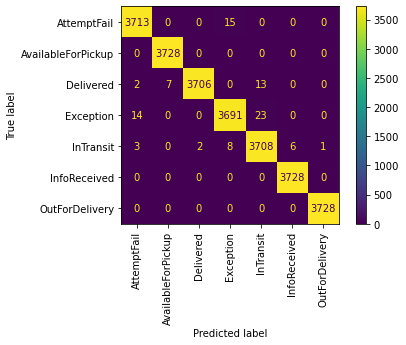

In [57]:
cm2=confusion_matrix(y_train_rs,xgb.predict(X_train_vector),labels=np.arange(0,7))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=code_map.values())
disp_train.plot()
plt.xticks(rotation=90)
plt.show()

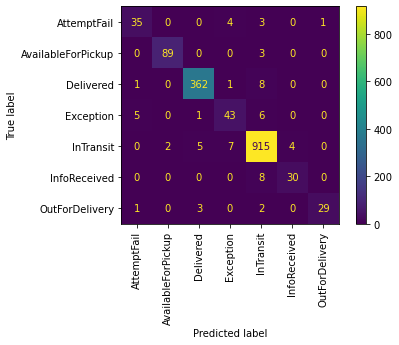

In [58]:
cm1=confusion_matrix(y_test,xgb.predict(X_test_vector),labels=np.arange(0,7))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=code_map.values())
disp_test.plot()
plt.xticks(rotation=90)
plt.show()

In [59]:
## Print out wrongly classified messages
dfx=pd.DataFrame(X_test)
dfy=pd.DataFrame(y_test)
dfy_=pd.DataFrame(xgb.predict(X_test_vector))
df_check=pd.concat([dfx,dfy,dfy_],axis=1)
df_check['true label']=df_check.iloc[:,1].map(code_map)
df_check['predict label']=df_check.iloc[:,2].map(code_map)
print(len(df_check[df_check['true label']!=df_check['predict label']]))
df_check[df_check['true label']!=df_check['predict label']]

65


,0,0,0,true label,predict label
24,Nadejście przesyłki,5,4,InfoReceived,InTransit
25,Modtagelse nægtet.,3,4,Exception,InTransit
26,Unable to deliver Reason: insuf address,3,0,Exception,AttemptFail
35,The Salvador Lara Ybarra Partner scans the pac...,5,4,InfoReceived,InTransit
45,PENDING_PICKUP,5,4,InfoReceived,InTransit
...,...,...,...,...,...
1464,In consegna,6,4,OutForDelivery,InTransit
1488,Siunta įteikta gavėjui,2,4,Delivered,InTransit
1496,"As requested, the UPS My Choice delivery chang...",4,2,InTransit,Delivered
1540,Arrived at DHL Delivery Facility MONTERREY - M...,5,4,InfoReceived,InTransit


In [60]:
## construct pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('vectorizer', vectorizer), ('XGBoost', xgb)])

In [61]:
def status_classify(status):
    if type(status)==str:
        status=[status]
    CLASS=pipe.predict(status)
    LABEL=[code_map[target] for target in CLASS]
    PROB=pipe.predict_proba(status)
    PROB.sort(axis=1)
    return list(zip(LABEL,PROB[:,-1]))

In [68]:
status_classify('Your item was delivered to the front desk, reception area, or mail room at 12:19 pm on October 17, 2022 in CHULA VISTA, CA 91911.')

[('Delivered', 0.90210766)]